# 3.SOH Degradation Analysis & Modeling

This notebook focuses on:
1. Analyzing SOH degradation trends over checkups
2. Quantifying degradation rates
3. Building regression models to predict SOH
4. Comparing linear and non-linear models

Input:
- Cycle-level feature dataset generated from Notebook 2

Output:
- SOH degradation insights
- Trained predictive models
- Model performance comparison


## 3.1 Set Up & Data Loading

### 3.1.1 Import Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File system
from pathlib import Path
import joblib

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Advanced model
from xgboost import XGBRegressor

# Misc
import warnings
warnings.filterwarnings("ignore")

### 3.1.2 Global Figure Configuration

In [16]:
# Global plotting style (clean, industry-like)
sns.set(style="whitegrid", context="talk")

# Figure base directory
FIG_DIR = Path("../figures")

# Subfolders
EDA_DIR = FIG_DIR / "eda"
MODEL_DIR = FIG_DIR / "modeling"

# Create folders if not exist
for d in [EDA_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Figure directories ready")


Figure directories ready


### 3.1.3 Load Feature Dataset

In [3]:
data_path = Path("../data/features")
feature_file = "battery_features_soh_ac01_ac02.csv"

df = pd.read_csv(data_path / feature_file)

print("Feature dataset loaded")
display(df.head())
print(df.info())

Feature dataset loaded


,cell_id,checkup_num_x,discharge_capacity_ah,duration_s_x,mean_current_a_x,min_voltage_v_x,checkup_num_y,bol_capacity_ah,duration_s_y,mean_current_a_y,min_voltage_v_y,soh
0,AC01,0,56.481591,11070.408,27.547249,2.50009,0,56.481591,11070.408,27.547249,2.50009,1.000000
1,AC01,1,55.913008,11975.144,27.936964,2.50009,0,56.481591,11070.408,27.547249,2.50009,0.989933
2,AC01,2,55.450377,18275.024,27.620310,2.50009,0,56.481591,11070.408,27.547249,2.50009,0.981742
3,AC01,4,52.188337,10700.773,27.743210,2.50009,0,56.481591,11070.408,27.547249,2.50009,0.923988
4,AC01,5,50.617659,10563.948,25.874018,2.50009,0,56.481591,11070.408,27.547249,2.50009,0.896180


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cell_id                21 non-null     object 
 1   checkup_num_x          21 non-null     int64  
 2   discharge_capacity_ah  21 non-null     float64
 3   duration_s_x           21 non-null     float64
 4   mean_current_a_x       21 non-null     float64
 5   min_voltage_v_x        21 non-null     float64
 6   checkup_num_y          21 non-null     int64  
 7   bol_capacity_ah        21 non-null     float64
 8   duration_s_y           21 non-null     float64
 9   mean_current_a_y       21 non-null     float64
 10  min_voltage_v_y        21 non-null     float64
 11  soh                    21 non-null     float64
dtypes: float64(9), int64(2), object(1)
memory usage: 2.1+ KB
None


### 3.1.4 Schema Validation

In [4]:
required_cols = {
    "cell_id",
    "checkup_num_x",
    "discharge_capacity_ah",
    "bol_capacity_ah",
    "duration_s_x",
    "mean_current_a_x",
    "min_voltage_v_x",
    "soh"
}

missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

print("Schema validation passed")

Schema validation passed


### 3.1.5 Column Renaming & Selection

In [5]:
# Column Renaming
df = df.rename(columns={
    "checkup_num_x": "checkup_num",
    "duration_s_x": "duration_s",
    "mean_current_a_x": "mean_current_a",
    "min_voltage_v_x": "min_voltage_v",
})

# Column Selection (Drop Unused Column)
df = df[
    [
        "cell_id",
        "checkup_num",
        "discharge_capacity_ah",
        "bol_capacity_ah",
        "duration_s",
        "mean_current_a",
        "min_voltage_v",
        "soh"
    ]
]

df.head()

,cell_id,checkup_num,discharge_capacity_ah,bol_capacity_ah,duration_s,mean_current_a,min_voltage_v,soh
0,AC01,0,56.481591,56.481591,11070.408,27.547249,2.50009,1.000000
1,AC01,1,55.913008,56.481591,11975.144,27.936964,2.50009,0.989933
2,AC01,2,55.450377,56.481591,18275.024,27.620310,2.50009,0.981742
3,AC01,4,52.188337,56.481591,10700.773,27.743210,2.50009,0.923988
4,AC01,5,50.617659,56.481591,10563.948,25.874018,2.50009,0.896180


### 3.1.6 Sorting (Time Order)

In [6]:
df = df.sort_values(
    ["cell_id", "checkup_num"]
).reset_index(drop=True)

print("Data sorted")

Data sorted


### 3.1.7 Degradation Rate (ΔSOH per Checkup)

In [7]:
df["soh_delta"] = (
    df.groupby("cell_id")["soh"]
      .diff()
      .fillna(0)
)

df.groupby("cell_id")["soh_delta"].mean()

cell_id
AC01   -0.036194
AC02   -0.022302
Name: soh_delta, dtype: float64

## 3.2 Model Implementation

### 3.2.1 Baseline Model — Linear Regression

In [8]:
X = df[["checkup_num"]]
y = df["soh"]

lin_model = LinearRegression()
lin_model.fit(X, y)

df["soh_pred_linear"] = lin_model.predict(X)

### 3.2.2 Non Linear Baseline — Random Forest

In [9]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    random_state=42
)

rf.fit(X, y)

df["soh_pred_rf"] = rf.predict(X)

### 3.2.3 Advanced Model — XGBoost

In [10]:
feature_cols = [
    "checkup_num",
    "discharge_capacity_ah",
    "duration_s",
    "mean_current_a",
    "min_voltage_v"
]

X = df[feature_cols]
y = df["soh"]

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X, y)

df["soh_pred_xgb"] = xgb.predict(X)

## 3.3 Model Evaluation

### 3.3.1 Performance Metrics

In [11]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(name)
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    print("-" * 30)

evaluate(y, df["soh_pred_linear"], "Linear Regression")
evaluate(y, df["soh_pred_rf"], "Random Forest")
evaluate(y, df["soh_pred_xgb"], "XGBoost")

Linear Regression
MAE : 0.0181
RMSE: 0.0266
R2  : 0.9214
------------------------------
Random Forest
MAE : 0.0099
RMSE: 0.0196
R2  : 0.9572
------------------------------
XGBoost
MAE : 0.0006
RMSE: 0.0007
R2  : 0.9999
------------------------------


### 3.3.2 Model Visualization

#### 3.3.2.1 Predicted vs Actual SOH (Model Comparison)

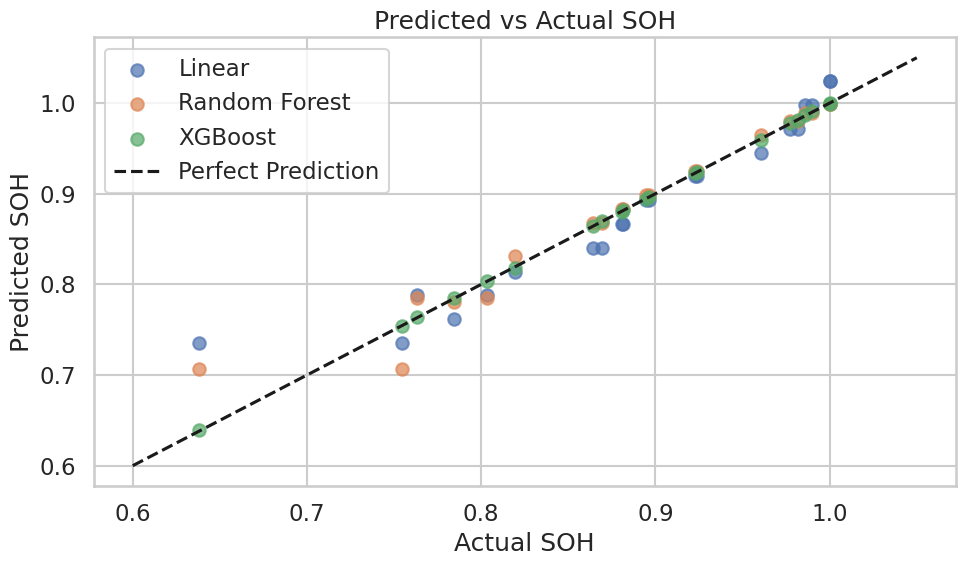

In [12]:
plt.figure(figsize=(10, 6))

plt.scatter(df["soh"], df["soh_pred_linear"], label="Linear", alpha=0.7)
plt.scatter(df["soh"], df["soh_pred_rf"], label="Random Forest", alpha=0.7)
plt.scatter(df["soh"], df["soh_pred_xgb"], label="XGBoost", alpha=0.7)

plt.plot([0.6, 1.05], [0.6, 1.05], "k--", label="Perfect Prediction")
plt.xlabel("Actual SOH")
plt.ylabel("Predicted SOH")
plt.title("Predicted vs Actual SOH")
plt.legend()
plt.tight_layout()

plt.savefig(MODEL_DIR / "predicted_vs_actual_soh.png", dpi=300)
plt.show()
plt.close()

#### 3.3.2.2 Model Performance Comparison (Bar Chart)

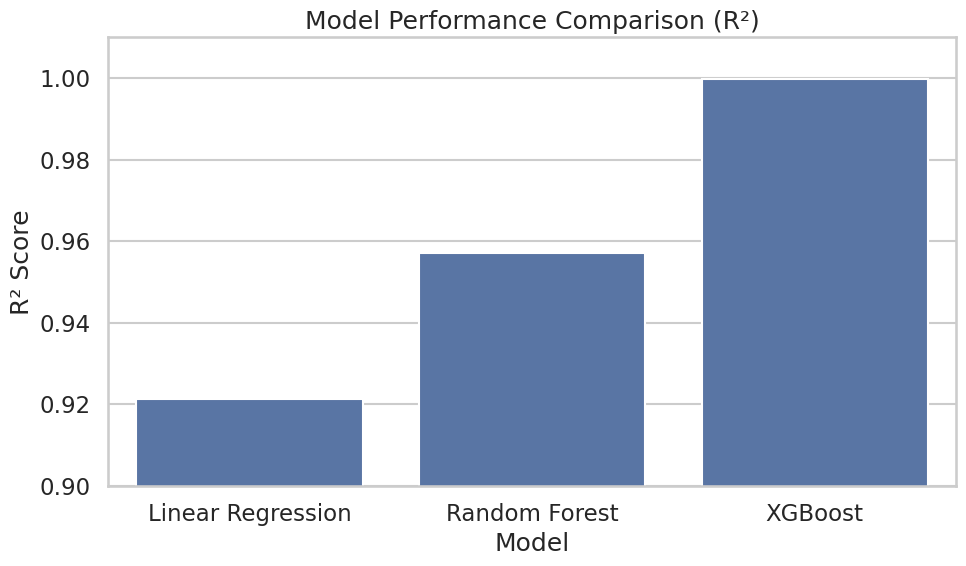

In [13]:
metrics_df = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "MAE": [0.0181, 0.0099, 0.0006],
    "RMSE": [0.0266, 0.0196, 0.0007],
    "R2": [0.9214, 0.9572, 0.9999]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Model", y="R2")
plt.title("Model Performance Comparison (R²)")
plt.ylabel("R² Score")
plt.ylim(0.9, 1.01)
plt.tight_layout()

plt.savefig(MODEL_DIR / "model_r2_comparison.png", dpi=300)
plt.show()
plt.close()

## 3.4 Results & Export

### 3.4.1 Save Results

In [14]:
folder_path = Path("../data/features")

output_file = folder_path / "battery_soh_model_results.csv"
df.to_csv(output_file, index=False)

print("Results saved:")
print(output_file.name)

Results saved:
battery_soh_model_results.csv


### 3.4.2 Save Models

In [15]:
model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)

joblib.dump(lin_model, model_dir / "linear_regression_soh.pkl")
joblib.dump(rf, model_dir / "random_forest_soh.pkl")
joblib.dump(xgb, model_dir / "xgboost_soh.pkl")

['../models/xgboost_soh.pkl']